# Problem 1

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [4]:
import TasmanianSG
import numpy as np

# imports specifically needed by the examples
import math
from random import uniform
from datetime import datetime

print("TasmanianSG version: {0:s}".format(TasmanianSG.__version__))
print("TasmanianSG license: {0:s}".format(TasmanianSG.__license__))

grid  = TasmanianSG.TasmanianSparseGrid()
grid1 = TasmanianSG.TasmanianSparseGrid()
grid2 = TasmanianSG.TasmanianSparseGrid()

TasmanianSG version: 4.0
TasmanianSG license: BSD 3-Clause


### Genz Test Functions

In [5]:
def oscillatory_func(x, c, w):
    return np.cos(2*np.pi*w[0] + np.sum(c * x))

In [6]:
def product_peak_func(x, c, w):
    return np.prod(c**(-2) + (x - w)**2)**(-1)

In [7]:
def corner_peak_func(x, c, w):
    return ( 1 + np.sum(c * x) )**(-(len(c) + 1))

In [8]:
def gaussian_func(x, c, w):
    return np.exp( -np.exp( -np.sum(c**2 * (x - w)**2) ) )

In [9]:
def continuous_func(x, c, w):
    return np.exp(-np.sum(c * np.abs(x - w)))

In [10]:
def discontinous_func(x, c, w):
    if x[0] > w[0] or x[1] > w[1]:
        return 0 
    else: 
        return np.exp(np.sum(c * x))

### Convergence Plot for Static Sparse Grid 

In [11]:
# EXAMPLE 1 for OSM:
# interpolate: f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
# using piecewise linear basis functions.

def convergence_plot(f, d, dim):
    
    c = np.repeat(0.5, d)   
    w = np.repeat(0.5, d)

    # 1000 2-dimensional sample points 
    aPnts = np.empty([1000, d])  
    for iI in range(1000):
        for iJ in range(d):
            aPnts[iI][iJ] = uniform(-1.0, 1.0)

    ### (Kei Comment) This is generating 1000 points on (x,y) grid uniformly so that we can use this 
    ### to evaluate how well the function is interpolating.

    # Result
    aTres = np.empty([1000,])
    for iI in range(1000):
        aTres[iI] = f(aPnts[iI], c, w)
    ### (Kei Comment) Getting the actual value of the function at these 1000 uniformly generated grid points.

    # Sparse Grid with dimension 2 and 1 output and refinement level 5
    iDim = d
    iOut = 1
    #iDepth = 2
    which_basis = 1 #1= linear basis functions -> Check the manual for other options

    #print("\n-------------------------------------------------------------------------------------------------")
    #print("Example 1 for OSM: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)")
    #print("       using fixed sparse grid with depth {0:1d}".format(iDepth))
    #print("       the error is estimated as the maximum from 1000 random points\n")

    
    errors = []
    for iDepth in range(dim):
    
        # construct sparse grid
        grid.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")  
        ### (Kei Comment) Creates sparse grid of points to evaluate function and interpolate
        aPoints = grid.getPoints()
        iNumP1 = aPoints.shape[0]
        aVals = np.empty([aPoints.shape[0], 1])
        for iI in range(aPoints.shape[0]):
            aVals[iI] = f(aPoints[iI], c, w)
        grid.loadNeededPoints(aVals)  
        ### (Kei Comment) Load these values and interpolate (based on sparse grid of points)

        # compute the error
        aRes = grid.evaluateBatch(aPnts)  
        ### (Kei Comment) evaluate how well the interpolation is doing by finding the error at the 1000 unformly 
        ### generated data points based on interpolation. 

        fError1 = max(np.fabs(aRes[:,0] - aTres))
        #print(" For localp    Number of points: {0:1d}   Max. Error: {1:1.16e}".format(iNumP1, fError1))
        
        errors.append(fError1)
    
    # write coordinates of grid to a text file
    f=open("fix_sparse_grid.txt", 'a')
    np.savetxt(f, aPoints, fmt='% 2.16f')
    f.close()
    
    return errors

/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


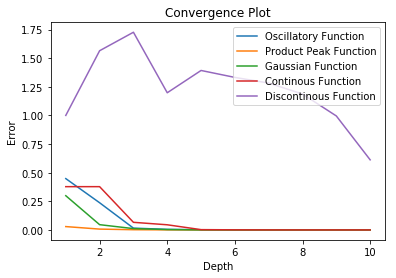

In [15]:
d = 10
depth = np.arange(1, d+1)
osc_error = convergence_plot(oscillatory_func, 2, d)
product_error = convergence_plot(product_peak_func, 2, d)
corner_error = convergence_plot(corner_peak_func, 2, d)
gaussian_error = convergence_plot(gaussian_func, 2, d)
cont_error = convergence_plot(continuous_func, 2, d)
discont_error = convergence_plot(discontinous_func, 2, d)

plt.figure()
plt.plot(depth, osc_error, label = 'Oscillatory Function')
plt.plot(depth, product_error,  label = 'Product Peak Function')
#plt.plot(depth, corner_error, label = 'Corner Peak Function')
plt.plot(depth, gaussian_error, label = 'Gaussian Function')
plt.plot(depth, cont_error, label = 'Continous Function')
plt.plot(depth, discont_error, label = 'Discontinous Function')

plt.title('Convergence Plot')
plt.xlabel('Depth')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.show()

### Exploring Adaptive Grid using Continous Function

In [25]:
## EXAMPLE 2 for OSM:
## interpolate: f(x,y) = exp(-x) / (1 + 100 * exp(-10 * y))
## using refinement

def adaptive_sparse_plot(f, d):
    
    # 1000 d-dimensional sample points
    c = np.repeat(0.5, d)   
    w = np.repeat(0.5, d)

    aPnts = np.empty([1000, d])  
    for iI in range(1000):
        for iJ in range(d):
            aPnts[iI][iJ] = uniform(-1.0, 1.0)

    aTres = np.empty([1000,])
    for iI in range(1000):
        aTres[iI] = f(aPnts[iI], c, w)

    # Adaptive Sparse Grid with dimension 2 and 1 output and maximum refinement level 5, refinement criterion.
    iDim = 2
    iOut = 1
    iDepth = 1
    fTol = 1.E-5
    which_basis = 1 
    refinement_level = 5

    # level of grid before refinement
    grid1.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")

    aPoints = grid1.getPoints()
    print(aPoints)
    aVals = np.empty([aPoints.shape[0], 1])
    for iI in range(aPoints.shape[0]):
        aVals[iI] = f(aPoints[iI], c, w)    

    grid1.loadNeededPoints(aVals)

    ### (Kei Comment) Initializing the sparse grid at that level iDepth (in this case 1). This is the 
    ### static sparse grid. We do this because sometimes we check at areas that may not be helpful.

    print("\n-------------------------------------------------------------------------------------------------")
    print("Example 2: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)")
    print("   the error is estimated as the maximum from 1000 random points")
    print("   tolerance is set at 1.E-5 and piecewise linear basis functions are used\n")

    print("               Classic refinement ")
    print(" refinement level         points     error   ")

    #refinement level
    for iK in range(refinement_level):
        grid1.setSurplusRefinement(fTol, -1, "fds")   #also use fds, or other rules
        aPoints = grid1.getNeededPoints()
        aVals = np.empty([aPoints.shape[0], 1])
        for iI in range(aPoints.shape[0]):
            aVals[iI] = math.cos(0.5 * math.pi * aPoints[iI][0]) * math.cos(0.5 * math.pi * aPoints[iI][1])
        grid1.loadNeededPoints(aVals)
        grid1.plotPoints2D()
        grid_points = grid1.getPoints()

        aRes = grid1.evaluateBatch(aPnts)
        fError1 = max(np.fabs(aRes[:,0] - aTres))

        print(" {0:9d} {1:9d}  {2:1.2e}".format(iK+1, grid1.getNumPoints(), fError1))

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(grid_points[:,0], grid_points[:,1], grid1.evaluateBatch(grid_points))
    plt.show()

    ### (Kei Comment) For each level, look at the possible grid surplus (coefficient). If coefficient bigger 
    ### than threshold evaluate function at that grid point. If not, do not evaluate function at that grid point. 
    ### Continue until threshold is met at that area in which case don't check children or stop because refinement level
    ### has been reached. 

    ### (Kei Comment) For value function, during each iteration the sparse grid evolves and gets bigger until some threshold.
    ### Also, for each iteration, has new sparse grid because the function has changed as new value function update.



    # write coordinates of grid to a text file
    f2=open("Adaptive_sparse_grid.txt", 'a')
    np.savetxt(f2, aPoints, fmt='% 2.16f')
    f2.close()

    grid2 = TasmanianSG.TasmanianSparseGrid()
    grid2.makeLocalPolynomialGrid(iDim, iOut, refinement_level+iDepth, which_basis, "localp")
    a = grid2.getNumPoints()

    print("\n-------------------------------------------------------------------------------------------------")
    print "   a fix sparse grid of level ", refinement_level+iDepth, " would consist of " ,a, " points"
    print("\n-------------------------------------------------------------------------------------------------\n")    

[[ 0.  0.]
 [ 0. -1.]
 [ 0.  1.]
 [-1.  0.]
 [ 1.  0.]]

-------------------------------------------------------------------------------------------------
Example 2: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
   the error is estimated as the maximum from 1000 random points
   tolerance is set at 1.E-5 and piecewise linear basis functions are used

               Classic refinement 
 refinement level         points     error   


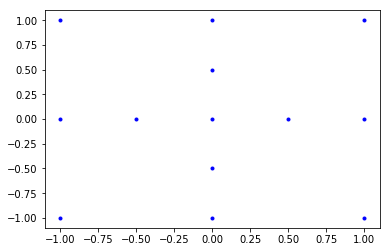

         1        13  3.51e+00


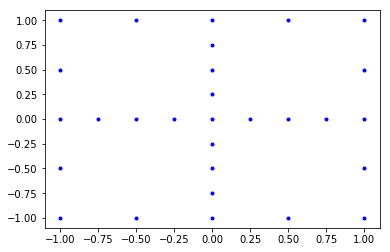

         2        29  3.57e+00


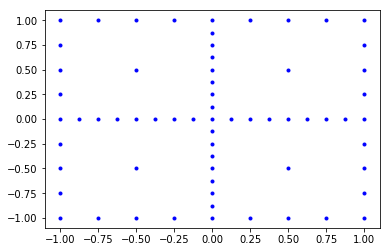

         3        65  3.69e+00


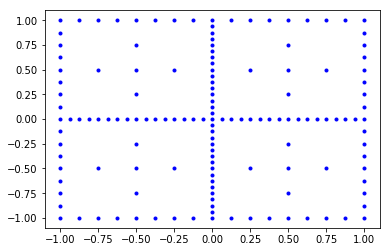

         4       145  3.72e+00


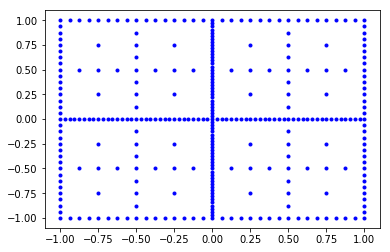

         5       321  3.68e+00


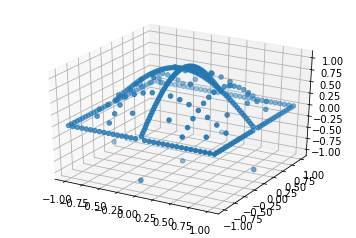


-------------------------------------------------------------------------------------------------
   a fix sparse grid of level  6  would consist of  321  points

-------------------------------------------------------------------------------------------------



In [26]:
adaptive_sparse_plot(oscillatory_func, 2)

[[ 0.  0.]
 [ 0. -1.]
 [ 0.  1.]
 [-1.  0.]
 [ 1.  0.]]

-------------------------------------------------------------------------------------------------
Example 2: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
   the error is estimated as the maximum from 1000 random points
   tolerance is set at 1.E-5 and piecewise linear basis functions are used

               Classic refinement 
 refinement level         points     error   


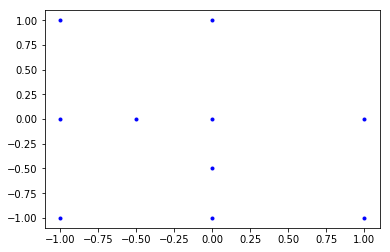

         1        10  1.24e+00


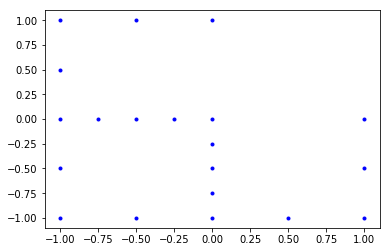

         2        20  1.52e+00


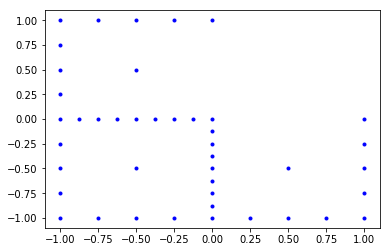

         3        43  1.60e+00


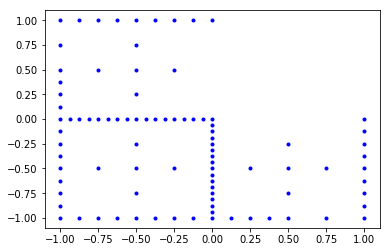

         4        91  1.71e+00


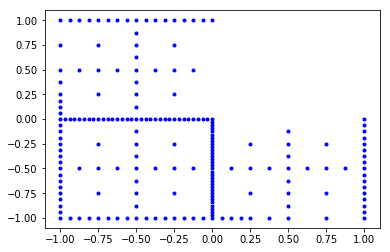

         5       195  1.68e+00


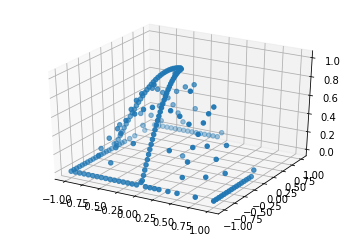


-------------------------------------------------------------------------------------------------
   a fix sparse grid of level  6  would consist of  321  points

-------------------------------------------------------------------------------------------------



In [27]:
adaptive_sparse_plot(product_peak_func, 2)

[[ 0.  0.]
 [ 0. -1.]
 [ 0.  1.]
 [-1.  0.]
 [ 1.  0.]]

-------------------------------------------------------------------------------------------------
Example 2: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
   the error is estimated as the maximum from 1000 random points
   tolerance is set at 1.E-5 and piecewise linear basis functions are used

               Classic refinement 
 refinement level         points     error   


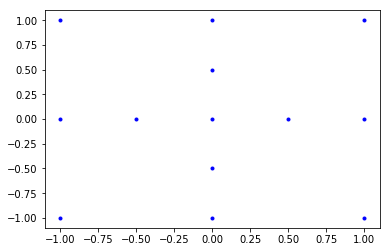

         1        13  4.60e+03


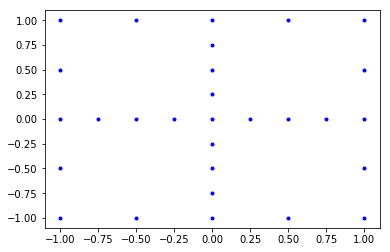

         2        29  4.60e+03


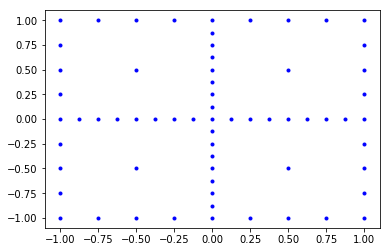

         3        65  4.61e+03


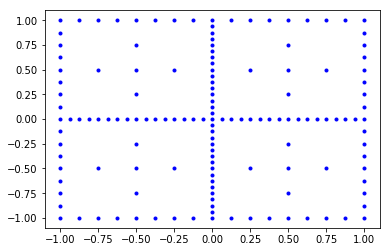

         4       145  4.61e+03


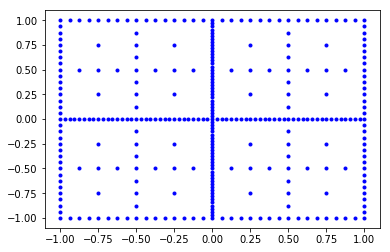

         5       321  4.60e+03


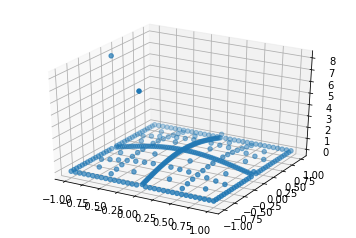


-------------------------------------------------------------------------------------------------
   a fix sparse grid of level  6  would consist of  321  points

-------------------------------------------------------------------------------------------------



In [28]:
adaptive_sparse_plot(corner_peak_func, 2)

[[ 0.  0.]
 [ 0. -1.]
 [ 0.  1.]
 [-1.  0.]
 [ 1.  0.]]

-------------------------------------------------------------------------------------------------
Example 2: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
   the error is estimated as the maximum from 1000 random points
   tolerance is set at 1.E-5 and piecewise linear basis functions are used

               Classic refinement 
 refinement level         points     error   


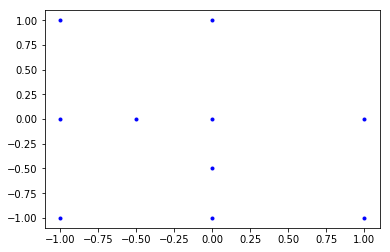

         1        10  7.16e-01


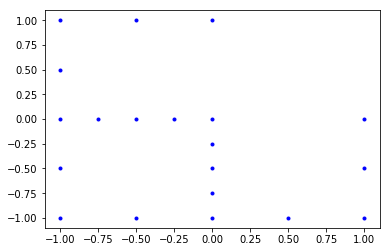

         2        20  1.04e+00


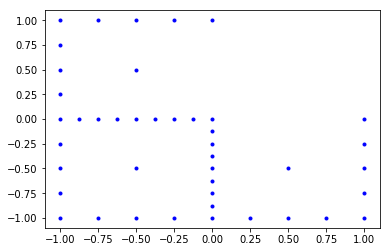

         3        43  1.15e+00


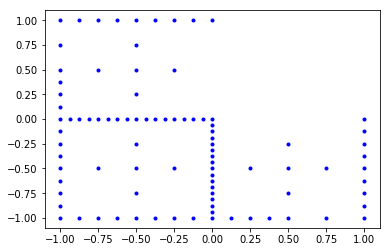

         4        91  1.21e+00


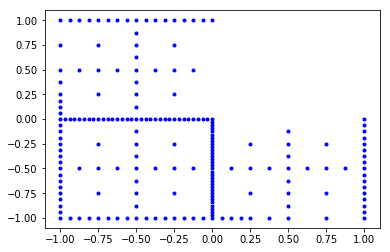

         5       195  1.01e+00


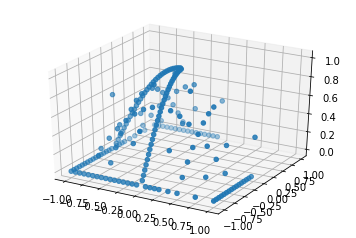


-------------------------------------------------------------------------------------------------
   a fix sparse grid of level  6  would consist of  321  points

-------------------------------------------------------------------------------------------------



In [29]:
adaptive_sparse_plot(gaussian_func, 2)

[[ 0.  0.]
 [ 0. -1.]
 [ 0.  1.]
 [-1.  0.]
 [ 1.  0.]]

-------------------------------------------------------------------------------------------------
Example 2: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
   the error is estimated as the maximum from 1000 random points
   tolerance is set at 1.E-5 and piecewise linear basis functions are used

               Classic refinement 
 refinement level         points     error   


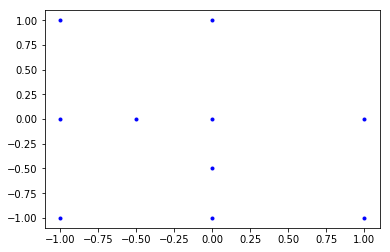

         1        10  3.84e-01


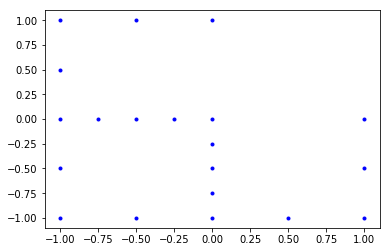

         2        20  6.35e-01


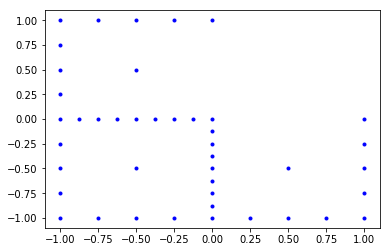

         3        43  7.23e-01


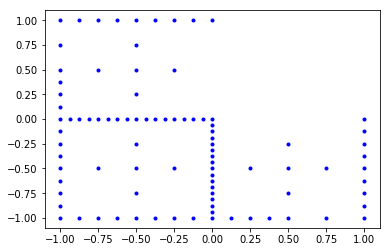

         4        91  7.40e-01


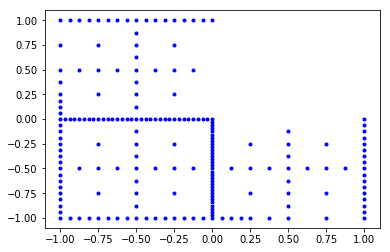

         5       195  7.48e-01


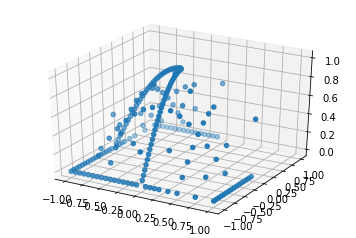


-------------------------------------------------------------------------------------------------
   a fix sparse grid of level  6  would consist of  321  points

-------------------------------------------------------------------------------------------------



In [30]:
adaptive_sparse_plot(continuous_func, 2)

[[ 0.  0.]
 [ 0. -1.]
 [ 0.  1.]
 [-1.  0.]
 [ 1.  0.]]

-------------------------------------------------------------------------------------------------
Example 2: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
   the error is estimated as the maximum from 1000 random points
   tolerance is set at 1.E-5 and piecewise linear basis functions are used

               Classic refinement 
 refinement level         points     error   


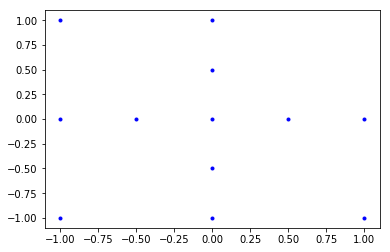

         1        12  1.03e+00


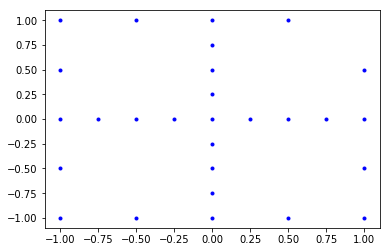

         2        28  9.54e-01


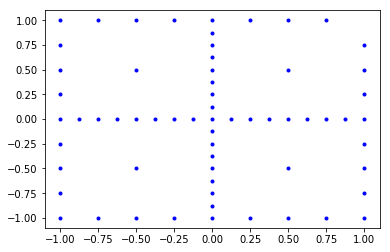

         3        64  1.04e+00


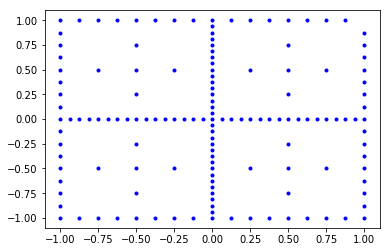

         4       144  1.07e+00


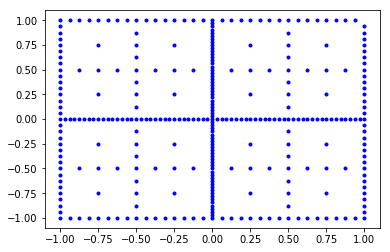

         5       320  1.10e+00


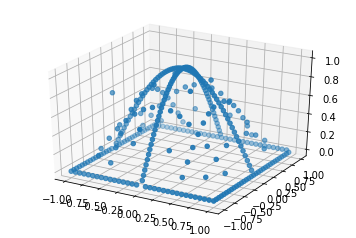


-------------------------------------------------------------------------------------------------
   a fix sparse grid of level  6  would consist of  321  points

-------------------------------------------------------------------------------------------------



In [31]:
adaptive_sparse_plot(discontinous_func, 2)

## Problem 2 